In [25]:
%pip install yfinance

In [62]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [129]:
tata = yf.download("TATASTEEL.NS", start="2023-11-02")
tata

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-02,114.599998,118.550003,114.599998,118.099998,118.099998,72538804


Define Tickers and Time Range

In [176]:
tickers = ['SPY','BND','GLD','QQQ','VTI','NSE']
# tickers = ['TATASTEEL.NS',"DALBHARAT.NS","MANINDS.NS","BIRLAMONEY.NS","SBILIFE.NS"]
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)
tickers

['SPY', 'BND', 'GLD', 'QQQ', 'VTI', 'NSE']

Download Adjusted Close Prices

In [177]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 calculate the lognormal returns for each asset and drop any missing values

In [178]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

Drop missing values

In [179]:
log_returns = log_returns.dropna()

calculate covariance matrix   (252 because of 252 trading days)

In [180]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI       NSE
SPY  0.049786  0.001579  0.002374  0.053593  0.050901  0.002536
BND  0.001579  0.003659  0.002828  0.001674  0.001725 -0.000540
GLD  0.002374  0.002828  0.022828  0.004119  0.002581 -0.001875
QQQ  0.053593  0.001674  0.004119  0.067319  0.054698 -0.000085
VTI  0.050901  0.001725  0.002581  0.054698  0.052450  0.002885
NSE  0.002536 -0.000540 -0.001875 -0.000085  0.002885  0.160832


Performance matrix

In [181]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Calculate the expected return

In [182]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

risk-free rate

In [183]:
risk_free_rate = 0.07325

Sharp Ratio

In [184]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

negative sharpe raatio

In [185]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

set constraints and bounds

In [186]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

set initial weights


In [187]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

optimize the weights to maximize the sharpe ratio

In [188]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

Analyze the Optimal Portfolio

In [189]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2000
BND: 0.0000
GLD: 0.4000
QQQ: 0.4000
VTI: 0.0000
NSE: 0.0000
Expected Annual Return: 0.1694
Expected Volatility: 0.1634
Sharpe Ratio: 0.5888


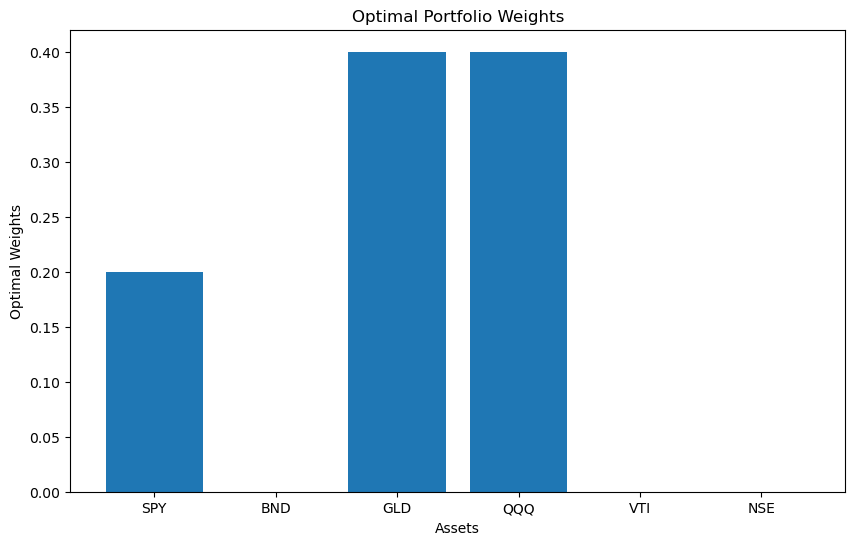

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()